<a href="https://colab.research.google.com/github/sebastianardila01/-Adivina-el-N-mero-en-PSeInt-/blob/main/MOVILIDAD_Y_TRANSPORTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# Proyecto: Movilidad Multimodal - Bogotá
#Realizado por:Sebastian Ardila
#Maria Rodriguez
#Kevin Perez
#ADSO
#Numero de Ficha:3065370l

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['grid.alpha'] = 0.3
sns.set_style("whitegrid")



In [45]:
# Opción A: si subes el CSV al entorno, usar:
csv_path = "/content/movilidad_bogota_multimodal.csv"  # subir archivo a Colab y usar esta ruta

# Opción B: si montas Google Drive:
# from google.colab import drive
# drive.mount('/content/drive')
# csv_path = '/content/drive/MyDrive/tu_carpeta/movilidad_bogota_multimodal.csv'

df = pd.read_csv(csv_path, parse_dates=[['date','time']])  # crea columna datetime
df.rename(columns={'date_time':'datetime'}, inplace=True) if 'date_time' in df.columns else None

# Si parse_dates no creó columna combinada, crearla:
if 'date_time' not in df.columns and 'datetime' not in df.columns:
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Mostrar
df.head()


/tmp/ipython-input-3555480470.py:9: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(csv_path, parse_dates=[['date','time']])  # crea columna datetime


,datetime,trip_id,mode,origin_zone,dest_zone,distance_km,duration_min,avg_speed_kmph,cost_cop,passengers,peak_hour,payment_method,weather,emissions_gCO2
0,2025-11-24 03:11:41,TRIP00001,bus,Suba,La Candelaria,23.84,86,16.63,2600,65,no,cash,clear,"1,855.50"
1,2025-02-27 19:05:53,TRIP00002,bus,Engativá,Kennedy,4.86,20,14.58,2800,38,yes,cash,clear,453.40
2,2025-01-13 08:54:52,TRIP00003,bus,Engativá,Fontibón,8.65,15,34.60,2600,54,yes,cash,clear,700.60
3,2025-05-21 04:57:34,TRIP00004,moto,Kennedy,Fontibón,4.26,8,31.95,5257,2,no,cash,cloudy,508.30
4,2025-05-06 06:16:46,TRIP00005,taxi,Engativá,Fontibón,9.56,13,44.12,18740,2,yes,cash,clear,"1,852.70"


In [46]:
# Información general
print("Filas:", len(df))
print("Columnas:", df.columns.tolist())
df.info()

# Mostrar valores nulos por columna
df.isna().sum()


Filas: 5000
Columnas: ['datetime', 'trip_id', 'mode', 'origin_zone', 'dest_zone', 'distance_km', 'duration_min', 'avg_speed_kmph', 'cost_cop', 'passengers', 'peak_hour', 'payment_method', 'weather', 'emissions_gCO2']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        5000 non-null   datetime64[ns]
 1   trip_id         5000 non-null   object        
 2   mode            5000 non-null   object        
 3   origin_zone     5000 non-null   object        
 4   dest_zone       5000 non-null   object        
 5   distance_km     5000 non-null   float64       
 6   duration_min    5000 non-null   int64         
 7   avg_speed_kmph  5000 non-null   float64       
 8   cost_cop        5000 non-null   int64         
 9   passengers      5000 non-null   int64         
 10  peak_hour       5000 non-null   object        


,0
datetime,0
trip_id,0
mode,0
origin_zone,0
dest_zone,0
distance_km,0
duration_min,0
avg_speed_kmph,0
cost_cop,0
passengers,0


In [47]:
# Asegurar tipos numéricos
numerical_cols = ['distance_km','duration_min','avg_speed_kmph','cost_cop','passengers','emissions_gCO2']
for c in numerical_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Manejando valores nulos: mostrar ejemplos
df[numerical_cols].describe()

# Opciones de imputación/filtrado:
#  - eliminar filas con datetime nulo o distance/duration nulos
df = df.dropna(subset=['datetime','distance_km','duration_min'])

# Recalcular avg_speed en caso de inconsistencias
df['duration_hr'] = df['duration_min'] / 60
df['avg_speed_kmph_calc'] = (df['distance_km'] / df['duration_hr']).replace([np.inf, -np.inf], np.nan)
# Si avg_speed_kmph está mal o NaN, rellenar con calculada
df['avg_speed_kmph'] = df['avg_speed_kmph'].fillna(df['avg_speed_kmph_calc']).round(2)

# Asegurar categorías como categoría
cat_cols = ['mode','origin_zone','dest_zone','peak_hour','payment_method','weather']
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

# Revisar duplicados por trip_id
if 'trip_id' in df.columns:
    dup_count = df['trip_id'].duplicated().sum()
    print("Trip_id duplicados:", dup_count)

df = df.drop_duplicates(subset=['trip_id'])  # si quieres eliminar duplicados exactos

# Resumen luego de limpieza
df.reset_index(drop=True, inplace=True)
df.info()


Trip_id duplicados: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             5000 non-null   datetime64[ns]
 1   trip_id              5000 non-null   object        
 2   mode                 5000 non-null   category      
 3   origin_zone          5000 non-null   category      
 4   dest_zone            5000 non-null   category      
 5   distance_km          5000 non-null   float64       
 6   duration_min         5000 non-null   int64         
 7   avg_speed_kmph       5000 non-null   float64       
 8   cost_cop             5000 non-null   int64         
 9   passengers           5000 non-null   int64         
 10  peak_hour            5000 non-null   category      
 11  payment_method       5000 non-null   category      
 12  weather              5000 non-null   category      
 13  emissions_g

In [48]:
# Estadísticas numéricas
desc_num = df[numerical_cols].describe().transpose()
desc_num

# Estadísticas por modo
stats_mode = df.groupby('mode')[numerical_cols].agg(['count','mean','median','std','min','max'])
# Un poco más amigable
pd.options.display.float_format = '{:,.2f}'.format
stats_mode


/tmp/ipython-input-4013982030.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_mode = df.groupby('mode')[numerical_cols].agg(['count','mean','median','std','min','max'])


distance_km                              duration_min               \
              count  mean median  std  min   max        count  mean median   
mode                                                                         
bicycle         553  4.26   4.27 2.21 0.52  7.99          553 16.97  17.00   
bus            2316 13.47  13.54 6.77 1.50 24.96         2316 49.96  50.00   
moto            617  7.94   7.83 4.13 1.01 14.98          617 13.76  13.00   
taxi           1514 10.71  10.61 5.51 1.01 19.97         1514 26.30  27.00   

               ... passengers                emissions_gCO2                    \
          std  ...     median   std min  max          count     mean   median   
mode           ...                                                              
bicycle  8.97  ...       1.00  0.00   1    1            553     0.00     0.00   
bus     21.80  ...      34.00 19.53   5  117           2316 1,076.73 1,055.75   
moto     8.49  ...       1.00  0.48   1    2            617   791.39   778.20   
taxi    13.14  ...       1.00  0.81   1    3           1514 2,034.54 1,997.75   

                                  
             std    min      max  
mode                              
bicycle     0.00   0.00     0.00  
bus       567.52  97.70 2,435.80  
moto      422.03  88.20 1,748.10  
taxi    1,067.16 171.20 4,319.50  

[4 rows x 36 columns]

mode
bus        2316
taxi       1514
moto        617
bicycle     553
Name: count, dtype: int64


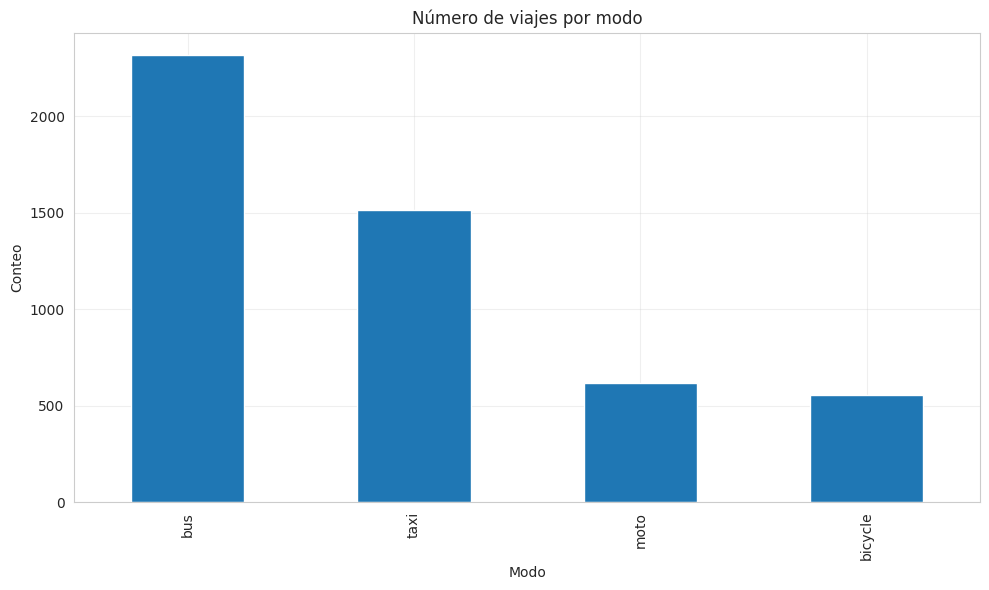

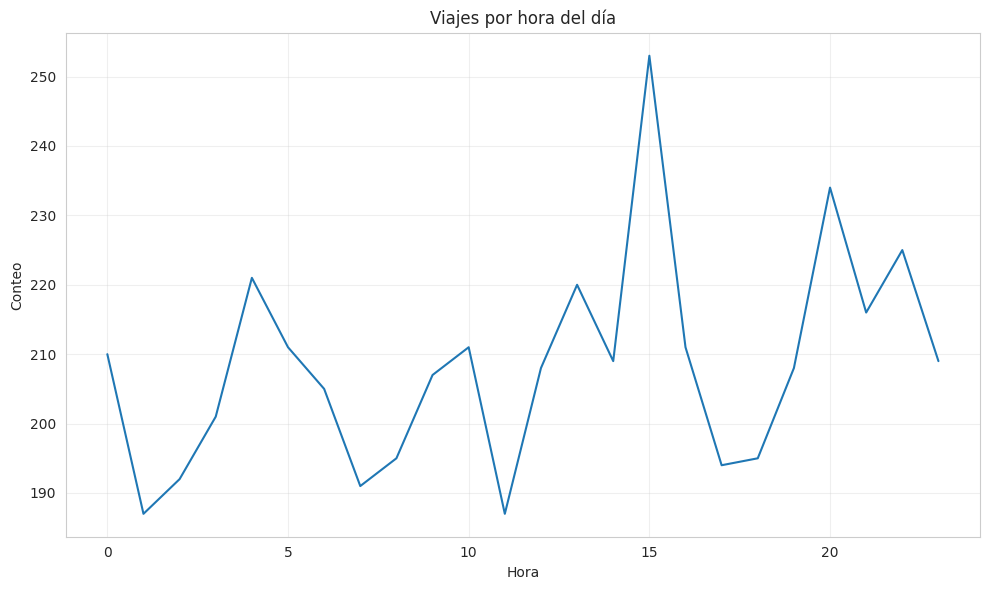

In [49]:
# Conteo por modo
mode_counts = df['mode'].value_counts()
print(mode_counts)

# Viajes por hora del día
df['hour'] = df['datetime'].dt.hour
hour_counts = df.groupby('hour').size()

# Plots
plt.figure()
mode_counts.plot(kind='bar')
plt.title('Número de viajes por modo')
plt.ylabel('Conteo')
plt.xlabel('Modo')
plt.tight_layout()
plt.savefig('viajes_por_modo.png')
plt.show()

plt.figure()
hour_counts.plot()
plt.title('Viajes por hora del día')
plt.xlabel('Hora')
plt.ylabel('Conteo')
plt.tight_layout()
plt.savefig('viajes_por_hora.png')
plt.show()


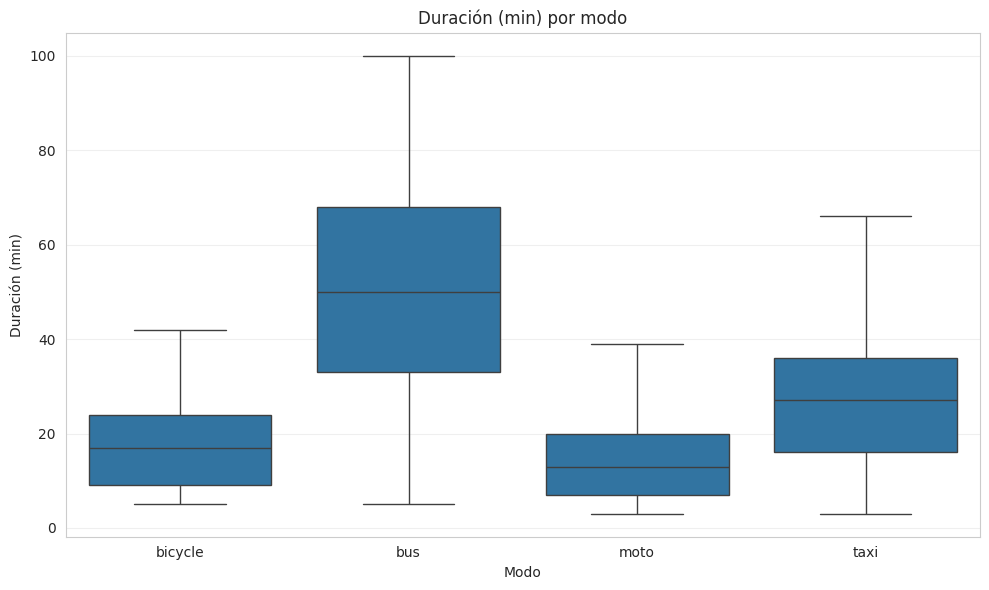

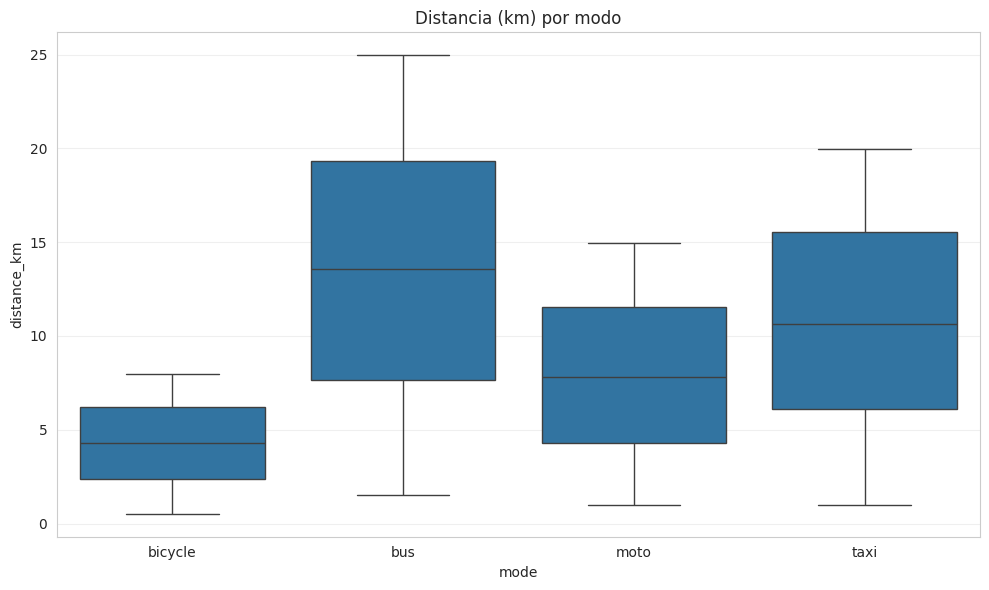

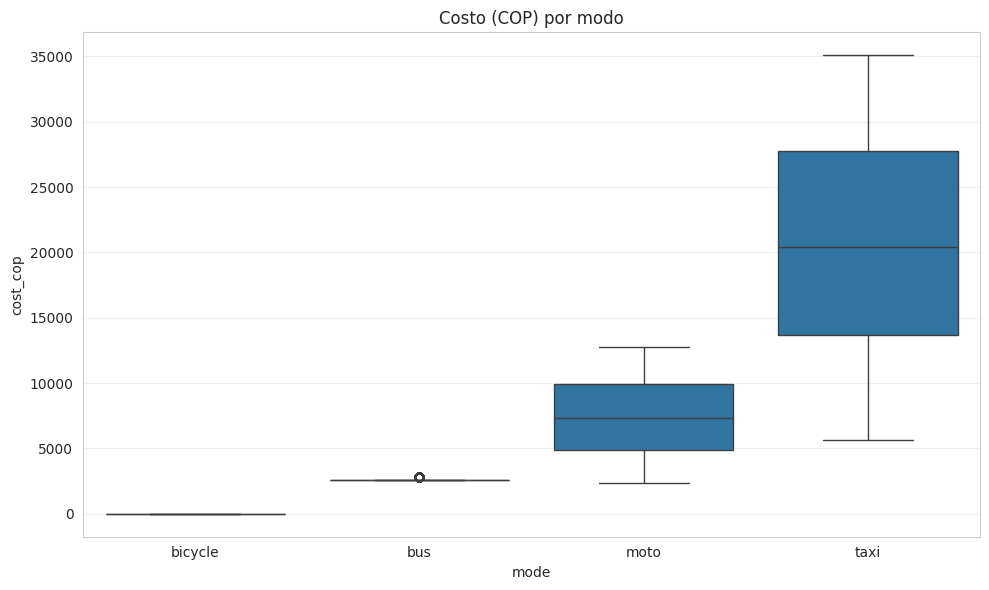

In [50]:
# Duración por modo
plt.figure()
sns.boxplot(x='mode', y='duration_min', data=df)
plt.title('Duración (min) por modo')
plt.ylabel('Duración (min)')
plt.xlabel('Modo')
plt.tight_layout()
plt.savefig('box_duration_by_mode.png')
plt.show()

# Distancia por modo
plt.figure()
sns.boxplot(x='mode', y='distance_km', data=df)
plt.title('Distancia (km) por modo')
plt.tight_layout()
plt.savefig('box_distance_by_mode.png')
plt.show()

# Costo por modo (avisar que bicycle tiene costo 0)
plt.figure()
sns.boxplot(x='mode', y='cost_cop', data=df)
plt.title('Costo (COP) por modo')
plt.tight_layout()
plt.savefig('box_cost_by_mode.png')
plt.show()


In [51]:
# Crear métricas nuevas
df['cost_per_km'] = df['cost_cop'] / df['distance_km'].replace(0, np.nan)
df['time_per_km_min'] = df['duration_min'] / df['distance_km'].replace(0, np.nan)
df['emissions_per_km'] = df['emissions_gCO2'] / df['distance_km'].replace(0, np.nan)
df[['cost_per_km','time_per_km_min','emissions_per_km']].describe().transpose()

# Agrupar por modo
efic_mode = df.groupby('mode')[['cost_per_km','time_per_km_min','emissions_per_km']].median().round(2)
efic_mode


/tmp/ipython-input-2477405152.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  efic_mode = df.groupby('mode')[['cost_per_km','time_per_km_min','emissions_per_km']].median().round(2)


,cost_per_km,time_per_km_min,emissions_per_km
mode,,,
bicycle,0.00,4.10,0.00
bus,194.54,3.69,79.81
moto,940.19,1.72,99.83
taxi,"1,922.38",2.44,189.44


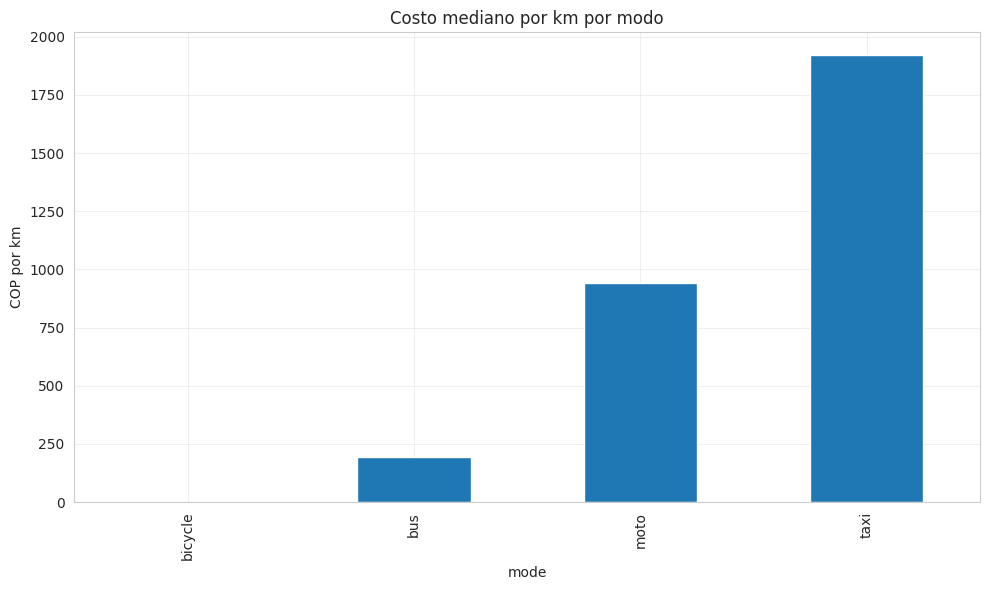

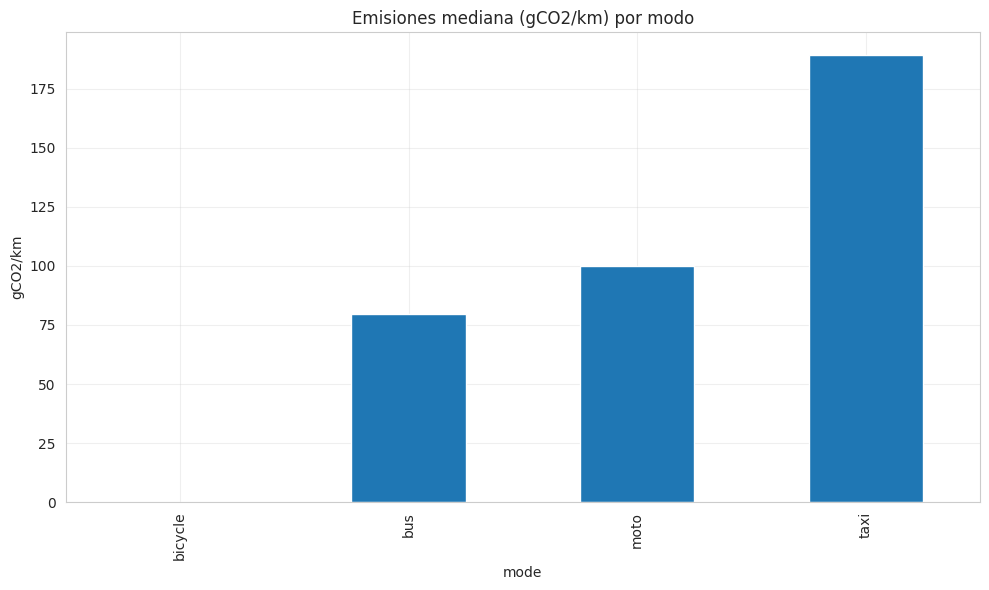

In [52]:
# Cost per km - median por modo
efic_mode['cost_per_km'].plot(kind='bar')
plt.title('Costo mediano por km por modo')
plt.ylabel('COP por km')
plt.tight_layout()
plt.savefig('cost_per_km_by_mode.png')
plt.show()

# Emisiones por km - median por modo
plt.figure()
efic_mode['emissions_per_km'].plot(kind='bar')
plt.title('Emisiones mediana (gCO2/km) por modo')
plt.ylabel('gCO2/km')
plt.tight_layout()
plt.savefig('emissions_per_km_by_mode.png')
plt.show()


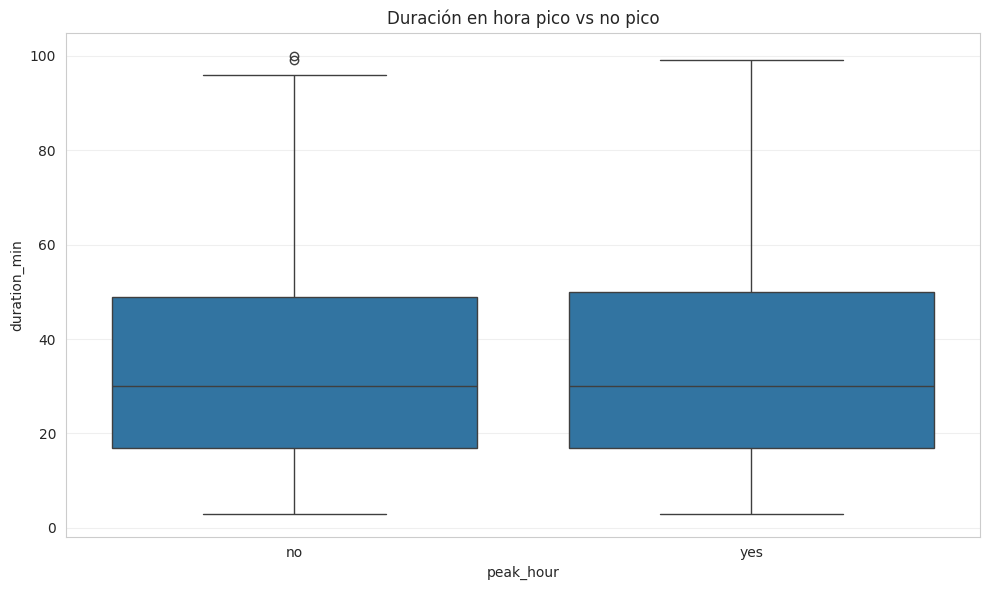

In [53]:
# Asegurar que peak_hour esté normalizado a yes/no
df['peak_hour'] = df['peak_hour'].astype(str).str.lower().map({'yes':'yes','no':'no'})

# Comparar duración y costo en hora pico
agg_peak = df.groupby('peak_hour')[['duration_min','cost_cop','distance_km']].median()
agg_peak

# Boxplot duración por peak
plt.figure()
sns.boxplot(x='peak_hour', y='duration_min', data=df)
plt.title('Duración en hora pico vs no pico')
plt.tight_layout()
plt.savefig('duration_peak_vs_nonpeak.png')
plt.show()

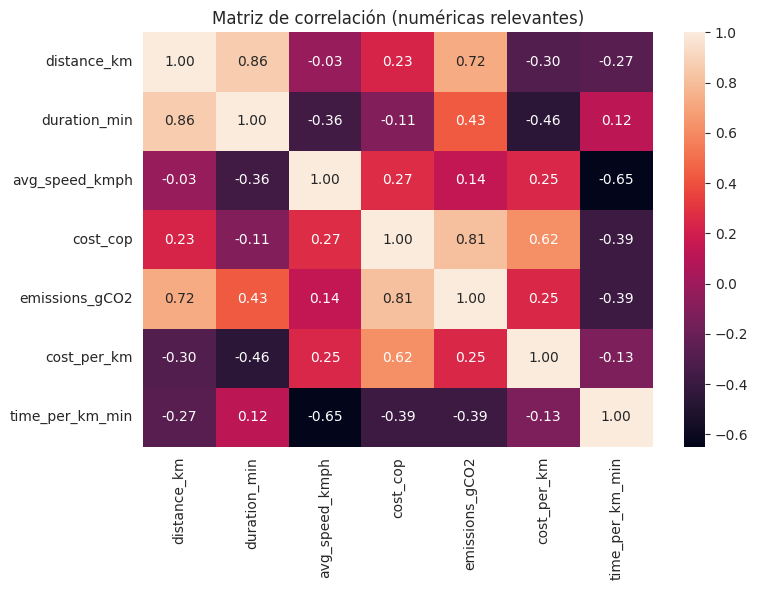

In [54]:
# Seleccionar numéricas relevantes
corr_cols = ['distance_km','duration_min','avg_speed_kmph','cost_cop','emissions_gCO2','cost_per_km','time_per_km_min']
corr = df[corr_cols].corr()
corr

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Matriz de correlación (numéricas relevantes)')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()


In [55]:
# Top zonas de origen y destino
top_orig = df['origin_zone'].value_counts().rename_axis('zone').reset_index(name='counts')
top_dest = df['dest_zone'].value_counts().rename_axis('zone').reset_index(name='counts')

print("Top origenes:\n", top_orig.head())
print("Top destinos:\n", top_dest.head())

# Tabla pivot: modo vs origin_zone (conteos)
pivot_mode_zone = pd.crosstab(df['origin_zone'], df['mode'])
pivot_mode_zone.to_excel('pivot_mode_zone.xlsx')
pivot_mode_zone.head()


Top origenes:
             zone  counts
0       Santa Fe     550
1           Bosa     539
2  La Candelaria     522
3      Chapinero     520
4       Engativá     503
Top destinos:
         zone  counts
0   Santa Fe     537
1    Kennedy     534
2  Chapinero     529
3       Bosa     509
4    Usaquén     498


mode,bicycle,bus,moto,taxi
origin_zone,,,,
Bosa,59,256,73,151
Chapinero,55,252,62,151
Engativá,60,243,58,142
Fontibón,47,218,61,145
Kennedy,44,213,62,137


In [56]:
# Emisiones totales por modo
emissions_mode = df.groupby('mode')['emissions_gCO2'].sum().sort_values(ascending=False)
emissions_mode

# Emisiones por pasajero-km aproximadas:
# asumimos emissions_gCO2 es total del vehículo; para buses dividimos por pasajeros
df['emissions_per_passenger_km'] = np.where(df['mode']=='bus',
                                            df['emissions_gCO2'] / df['passengers'] / df['distance_km'].replace(0, np.nan),
                                            df['emissions_gCO2'] / df['distance_km'].replace(0, np.nan))
# Agrupar mediana por modo
df.groupby('mode')['emissions_per_passenger_km'].median().round(2)


/tmp/ipython-input-42368434.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emissions_mode = df.groupby('mode')['emissions_gCO2'].sum().sort_values(ascending=False)
/tmp/ipython-input-42368434.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('mode')['emissions_per_passenger_km'].median().round(2)


,emissions_per_passenger_km
mode,
bicycle,0.00
bus,2.34
moto,99.83
taxi,189.44


In [57]:
# Guardar CSV limpio con nuevas columnas
output_dir = '/content/output'
os.makedirs(output_dir, exist_ok=True)
clean_path = os.path.join(output_dir, 'movilidad_bogota_multimodal_clean.csv')
df.to_csv(clean_path, index=False)
print("CSV limpio guardado en:", clean_path)

# Guardar resumen estadístico en Excel
stats_mode.to_excel(os.path.join(output_dir, 'stats_by_mode.xlsx'))
desc_num.to_csv(os.path.join(output_dir, 'stats_numeric_summary.csv'))
print("Resúmenes guardados en:", output_dir)


CSV limpio guardado en: /content/output/movilidad_bogota_multimodal_clean.csv
Resúmenes guardados en: /content/output


In [58]:
# Listar archivos generados (si estás en Colab)
import glob
files = glob.glob('/content/*.png') + glob.glob('/content/*.xlsx') + glob.glob('/content/output/*')
files


['/content/correlation_matrix.png',
 '/content/box_cost_by_mode.png',
 '/content/emissions_per_km_by_mode.png',
 '/content/box_duration_by_mode.png',
 '/content/cost_per_km_by_mode.png',
 '/content/duration_peak_vs_nonpeak.png',
 '/content/box_distance_by_mode.png',
 '/content/viajes_por_modo.png',
 '/content/viajes_por_hora.png',
 '/content/pivot_mode_zone.xlsx',
 '/content/output/stats_numeric_summary.csv',
 '/content/output/summary_text.txt',
 '/content/output/stats_by_mode.xlsx',
 '/content/output/movilidad_bogota_multimodal_clean.csv']

In [59]:
# Generar texto resumen automático (puedes copiar y pulir para el documento técnico)
total_trips = len(df)
trips_by_mode = df['mode'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
median_duration = df.groupby('mode')['duration_min'].median().round(1)
median_cost = df.groupby('mode')['cost_cop'].median().round(0)

print(f"Total de viajes: {total_trips}")
print("Porcentaje por modo:\n", trips_by_mode)
print("Duración mediana por modo (min):\n", median_duration)
print("Costo mediano por modo (COP):\n", median_cost)

# Guardar este pequeño resumen a txt
summary_text = f"""
Total de viajes: {total_trips}
Porcentaje por modo:
{trips_by_mode.to_string()}

Duración mediana por modo (min):
{median_duration.to_string()}

Costo mediano por modo (COP):
{median_cost.to_string()}
"""
with open(os.path.join(output_dir,'summary_text.txt'),'w') as f:
    f.write(summary_text)
print("Resumen guardado en output/summary_text.txt")


Total de viajes: 5000
Porcentaje por modo:
 mode
bus        46.32%
taxi       30.28%
moto       12.34%
bicycle    11.06%
Name: proportion, dtype: object
Duración mediana por modo (min):
 mode
bicycle   17.00
bus       50.00
moto      13.00
taxi      27.00
Name: duration_min, dtype: float64
Costo mediano por modo (COP):
 mode
bicycle        0.00
bus        2,600.00
moto       7,298.00
taxi      20,431.00
Name: cost_cop, dtype: float64
Resumen guardado en output/summary_text.txt


/tmp/ipython-input-2819604764.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_duration = df.groupby('mode')['duration_min'].median().round(1)
/tmp/ipython-input-2819604764.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_cost = df.groupby('mode')['cost_cop'].median().round(0)
